In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
from timm.models.layers import trunc_normal_

import matplotlib.pyplot as plt

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

c:\Users\Marawam\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Marawam\AppData\Local\Programs\Python\Python313\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# Set all seeds for reproducibility
import random
import os

def set_seed(seed=42):
    # Python
    random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    # Environment variables (for CUDA)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # PyTorch deterministic mode (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- False


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0,
          scheduler=None,
          device=device)-> List: # Add device argument
    # ----------- <Your code> ---------------


    model.train()
    train_loss = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)


        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        train_loss.append(loss.item())

        if batch_idx % (len(train_loader) // 10) == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')


    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:

    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Sum up batch loss
            test_loss += loss_fn(outputs, labels).item() * images.size(0)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Store predictions
            predictions.append(predicted)

    # Concatenate all predictions
    all_predictions = torch.cat(predictions)

    # Calculate average loss
    test_loss /= total_num

    # Calculate accuracy
    accuracy = correct / total_num

    # Create test statistics dictionary
    test_stat = {
        "loss": test_loss,
        "accuracy": accuracy,
        "prediction": all_predictions.cpu()  # Move predictions back to CPU
    }

    # Print log
    print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")


    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


C:\Users\Marawam\AppData\Local\Temp\ipykernel_2104\1860675223.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


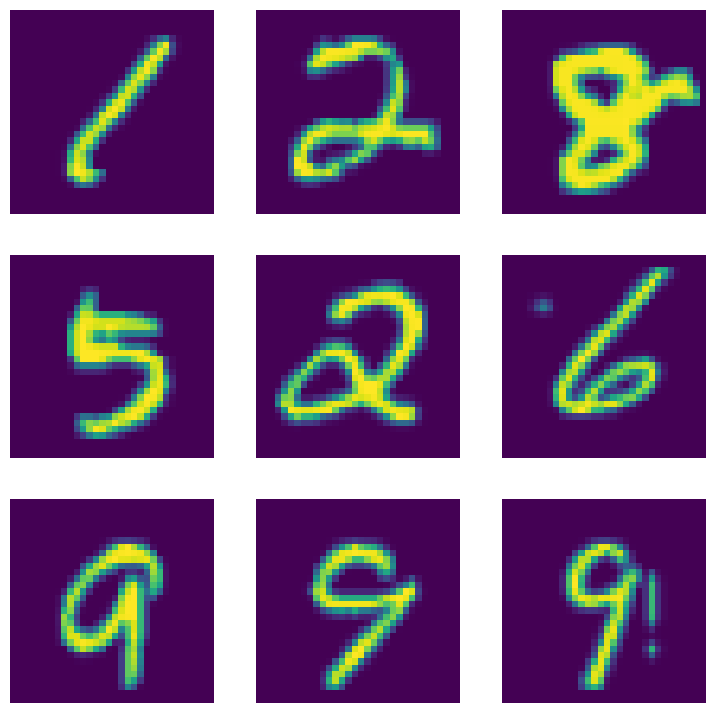

In [6]:
# Download MNIST and transformation
IMG_SIZE = 32
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
fig.show()

In [7]:
images, labels = next(iter(train_loader))

# Check the shape of the entire batch
print("Batch shape:", images.shape)

# Check the shape of the first image in the batch
print("Single image shape:", images[0].shape)

Batch shape: torch.Size([32, 1, 32, 32])
Single image shape: torch.Size([1, 32, 32])


In [8]:
from recursive_tnt import RTNT

In [9]:
rtnt = RTNT(num_classes=10)

demo_img = torch.randn(1, 1, 32, 32).to(device)
print(demo_img.shape)

summary(model=rtnt,
        input_size=demo_img.shape)

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
RTNT                                     [1, 10]                   4,920
├─PatchEmbed: 1-1                        [64, 4, 6]                --
│    └─Unfold: 2-1                       [1, 64, 16]               --
│    └─Conv2d: 2-2                       [64, 6, 2, 2]             12
├─LayerNorm: 1-2                         [16, 4, 24]               48
├─Linear: 1-3                            [16, 4, 24]               576
├─LayerNorm: 1-4                         [16, 4, 24]               48
├─LayerNorm: 1-5                         [1, 16, 96]               192
├─Linear: 1-6                            [1, 16, 96]               9,216
├─LayerNorm: 1-7                         [1, 16, 96]               192
├─Dropout: 1-8                           [1, 17, 96]               --
├─ModuleList: 1-9                        --                        --
│    └─Block: 2-3                        [64, 4, 6]                --
│    │

In [ ]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 5
# ----------- <Your code> ---------------
# Initialize FC model and move to device
net2 = RTNT().to(device)
optimizer = optim.Adam(net2.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.96)

all_train_losses = []
# Train for max_epoch epochs
for epoch in range(1, max_epoch + 1):
    # Train
    train_loss = train(net2, criterion, optimizer, train_loader, epoch)
    all_train_losses.extend(train_loss)
    # Test
    test_stat = test(net2, criterion, test_loader, epoch)

    print(f'Epoch {epoch} finished with accuracy: {100*test_stat["accuracy"]:.2f}%')


# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.391


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# For batch-wise plot
plt.figure(figsize=(10, 4))
plt.plot(all_train_losses, label='Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.grid(True)
plt.show()